In [25]:
from pathlib import Path
import sys

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

import numpy as np
import pandas as pd  
from data.preprocess import read_txn_data , preprocess_txn_data, compute_lob_features, \
    create_lob_dataset, merge_txn_and_lob
from models.deseasonalization import deses
import matplotlib.pyplot as plt

In [26]:
config = {
    "data_split": {
        "train_size": 0.7,
        "validation_size": 0.1,
        "test_size": 0.2
    },
    "model_params": {
        "learning_rate": 0.001,
        "batch_size": 10000,
        "epochs": 10
        ,
    }
}

In [27]:


freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])
df_des["log_deseasoned_total_volume"] = np.log(df_des["deseasoned_total_volume"] + 1e-6)

KeyboardInterrupt: 

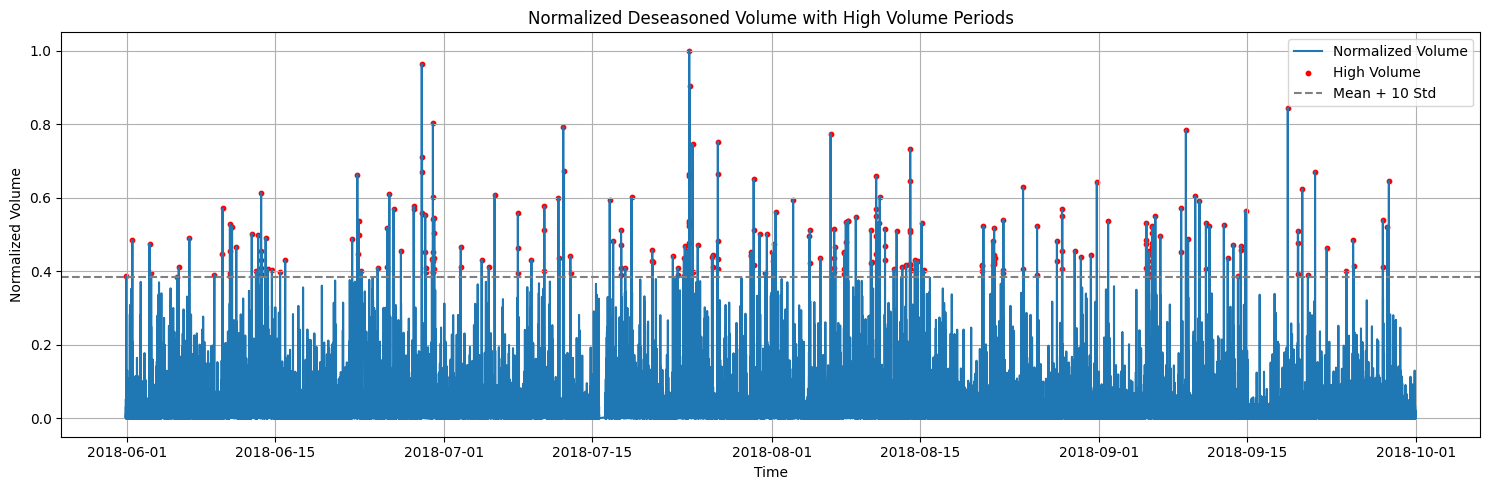

Mean: 0.015309607806310648, Std: 0.036999985924672844, Threshold: 0.3853094670530391
1.2227488151658767


C:\Users\peter\AppData\Local\Temp\ipykernel_27788\713617860.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_volume['gap'] = (high_volume['datetime'].diff() != pd.Timedelta(minutes=1)).cumsum()


In [ ]:
trx_df['normalized_volume'] = trx_df['deseasoned_total_volume'] / trx_df['deseasoned_total_volume'].max()

# Compute threshold
mean_volume = trx_df['normalized_volume'].mean()
std_volume = trx_df['normalized_volume'].std()
threshold = mean_volume + 10*std_volume
# Identify high volume periods
high_volume = trx_df[trx_df['normalized_volume'] > threshold]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(trx_df['datetime'], trx_df['normalized_volume'], label='Normalized Volume')
plt.scatter(high_volume['datetime'], high_volume['normalized_volume'], color='red', label='High Volume', s=10)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Mean + 10 Std')
plt.title('Normalized Deseasoned Volume with High Volume Periods')
plt.xlabel('Time')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
print(f"Mean: {mean_volume}, Std: {std_volume}, Threshold: {threshold}")


# Identify continuous periods
high_volume['gap'] = (high_volume['datetime'].diff() != pd.Timedelta(minutes=1)).cumsum()
period_lengths = high_volume.groupby('gap').size()
# Calculate average period length in minutes
average_length = period_lengths.mean()
print(average_length)

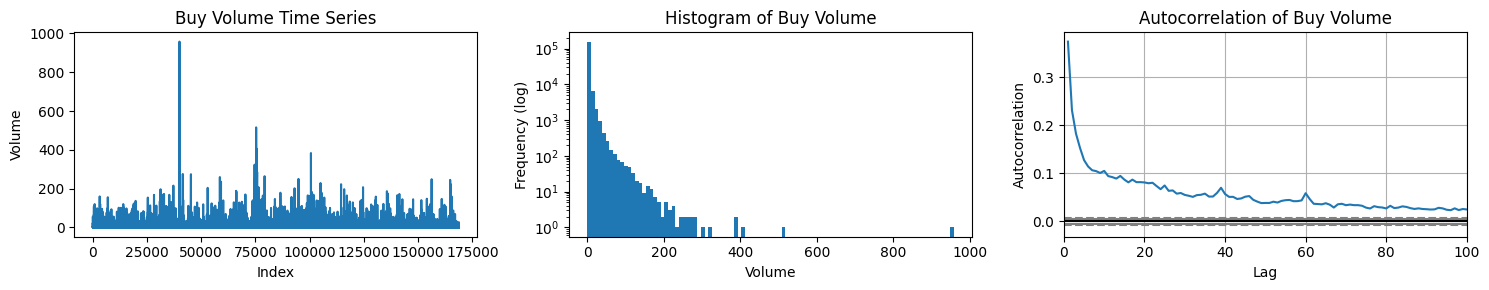

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# 1. Time series plot
trx_df["buy_volume"].plot(ax=axes[0])
axes[0].set_title("Buy Volume Time Series")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Volume")

# 2. Histogram (log y-scale to reveal tail better)
trx_df["buy_volume"].plot(kind="hist", bins=100, ax=axes[1], logy=True)
axes[1].set_title("Histogram of Buy Volume")
axes[1].set_xlabel("Volume")
axes[1].set_ylabel("Frequency (log)")

# 3. Autocorrelation function (ACF)
autocorrelation_plot(trx_df["buy_volume"], ax=axes[2])
axes[2].set_title("Autocorrelation of Buy Volume")
axes[2].set_xlim(0, 100)  # Limit lag for clarity

plt.tight_layout()
plt.show()


Could not fit Log-Normal: Invalid values in `data`.  Maximum likelihood estimation with 'lognorm' requires that 0.0 < (x - loc)/scale  < inf for each x in `data`.


C:\Users\peter\AppData\Local\Temp\ipykernel_27788\4232863354.py:57: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(pdf_vals))
c:\Users\peter\anaconda3\envs\torch_gpu\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


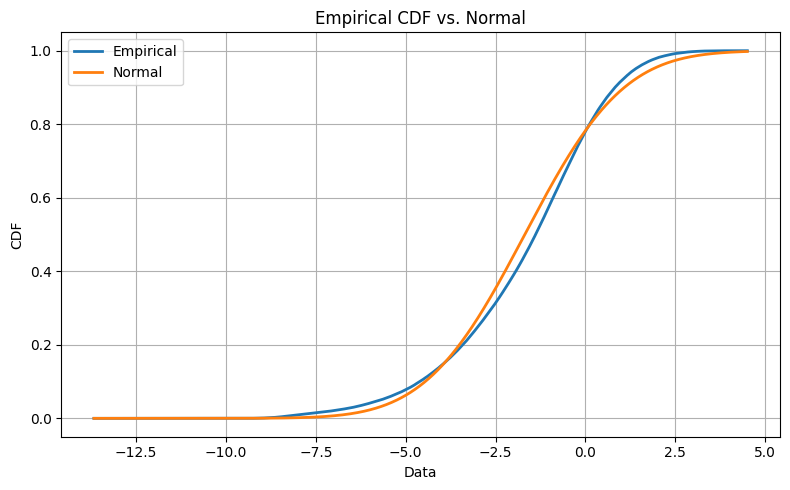

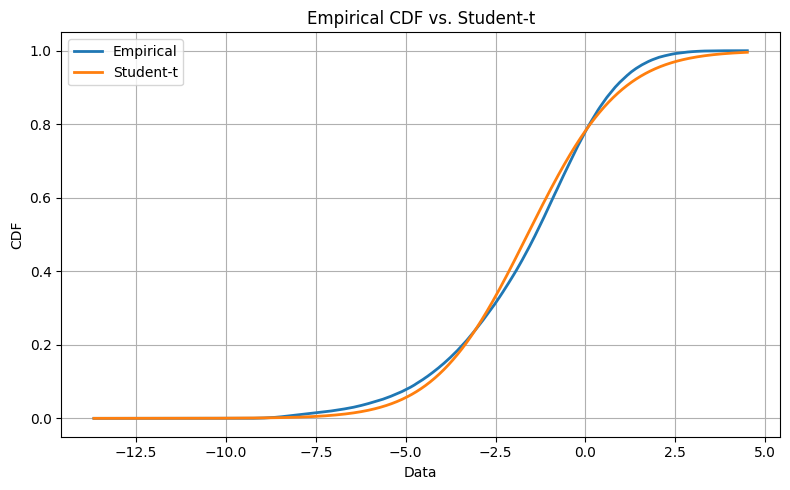

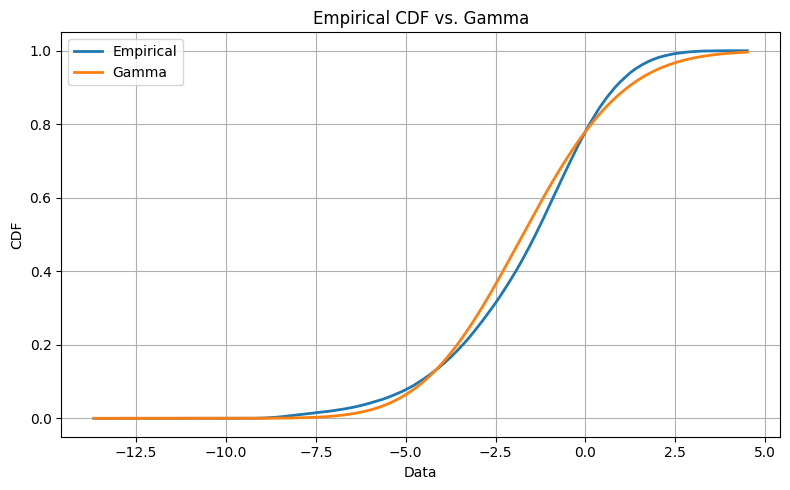

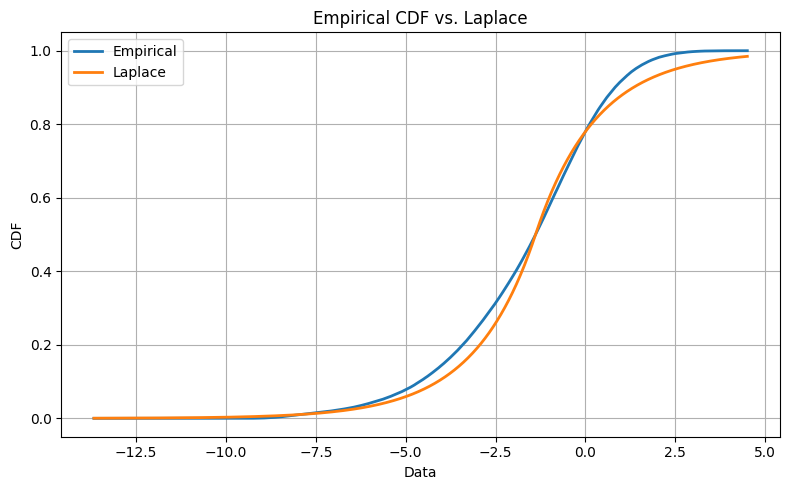

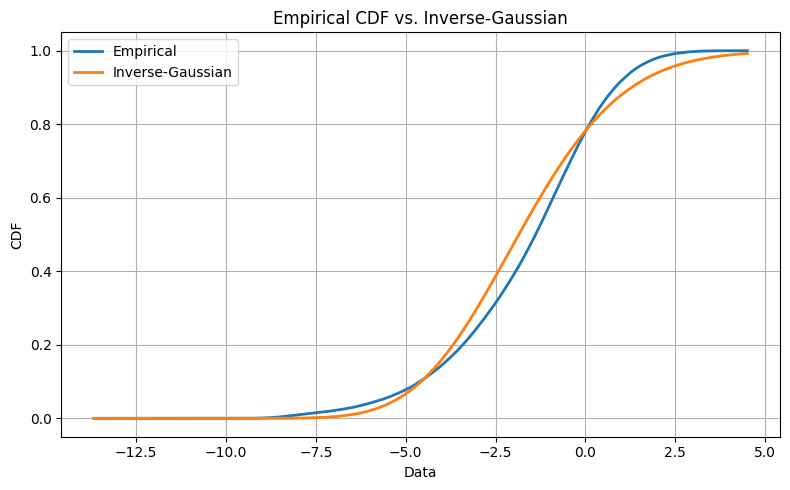

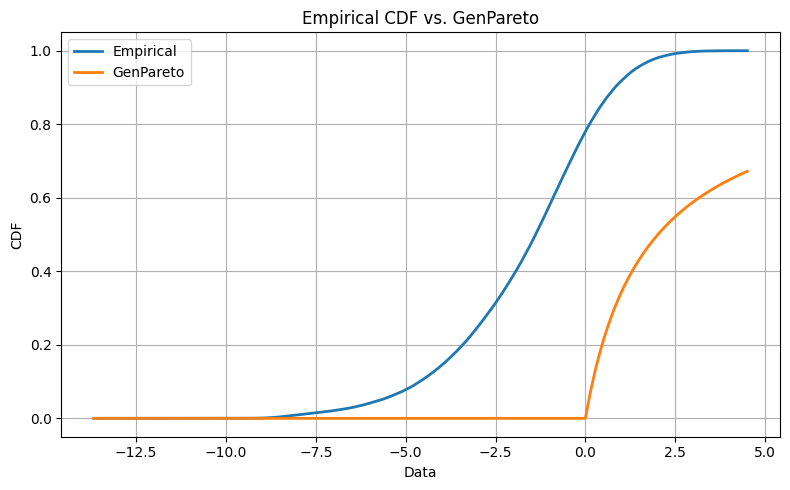

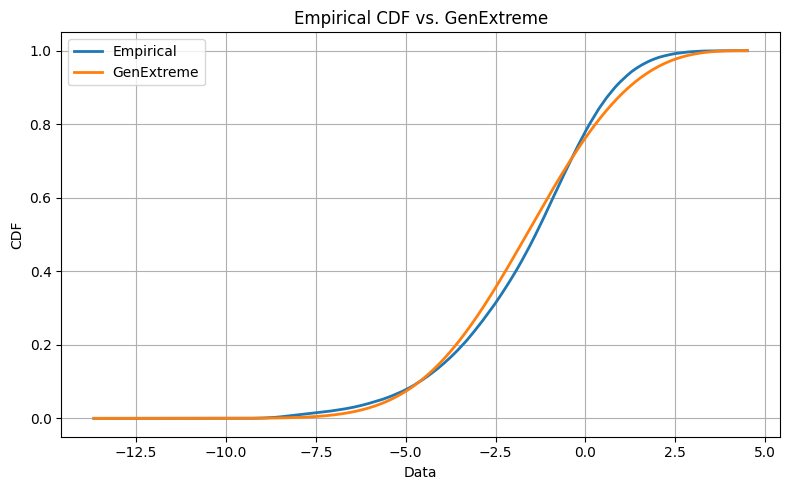

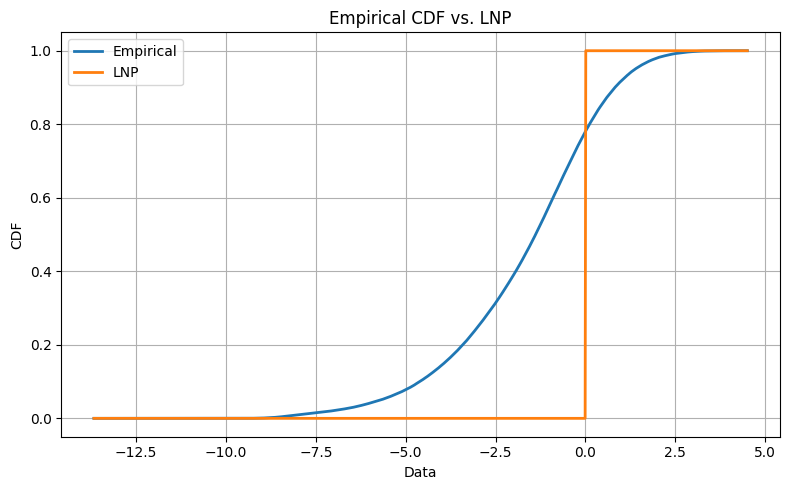


Kolmogorov-Smirnov Statistics:
Normal         : 0.057133
Student-t      : 0.043819
Gamma          : 0.065796
Laplace        : 0.056910
Inverse-Gaussian: 0.086108
GenPareto      : 0.779196
GenExtreme     : 0.048924
LNP            : 0.779196

Best fitting model: Student-t (KS = 0.043819)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, genpareto, invgauss, gamma, t, norm, laplace, genextreme
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF

# Convert to numpy array
data = df_des["log_deseasoned_total_volume"] 

# ECDF
ecdf = ECDF(data)
x = np.linspace(np.min(data), np.max(data), 1000)
ecdf_y = ecdf(x)

# Fit standard distributions
fitted = {}

# Distributions to fit from scipy.stats
distribution_defs = {
    "Normal": norm,
    "Student-t": t,
    "Log-Normal": lognorm,
    "Gamma": gamma,
    "Laplace": laplace,
    "Inverse-Gaussian": invgauss,
    "GenPareto": genpareto,
    "GenExtreme": genextreme
}

for name, dist in distribution_defs.items():
    try:
        if name == "Log-Normal":
            params = dist.fit(data, floc=0)
        elif name == "GenPareto":
            shifted_data = data - np.min(data)
            params = dist.fit(shifted_data)
        else:
            params = dist.fit(data)
        cdf_vals = dist.cdf(x, *params)
        fitted[name] = {"dist": dist, "params": params, "cdf": cdf_vals}
    except Exception as e:
        print(f"Could not fit {name}: {e}")

# --- Custom Log-Normal–Pareto Composite (LNP) ---
def lnp_cdf(x, mu, sigma, xm, alpha):
    return np.where(x <= xm,
                    lognorm.cdf(x, sigma, scale=np.exp(mu)),
                    1 - (xm / x)**alpha)

def lnp_neg_loglik(params):
    mu, sigma, xm, alpha = params
    if sigma <= 0 or alpha <= 0 or xm <= 0:
        return np.inf
    cdf_vals = lnp_cdf(data, mu, sigma, xm, alpha)
    cdf_vals = np.clip(cdf_vals, 1e-10, 1-1e-10)
    pdf_vals = np.gradient(cdf_vals, edge_order=2)
    return -np.sum(np.log(pdf_vals))

init_params = [np.mean(data), np.std(data), np.percentile(data, 70), 2.0]
bounds = [(None, None), (1e-6, None), (1e-6, None), (1e-6, None)]
res = minimize(lnp_neg_loglik, init_params, bounds=bounds)
mu_lnp, sigma_lnp, xm_lnp, alpha_lnp = res.x
cdf_lnp = lnp_cdf(x, mu_lnp, sigma_lnp, xm_lnp, alpha_lnp)
fitted["LNP"] = {"dist": "Custom", "params": (mu_lnp, sigma_lnp, xm_lnp, alpha_lnp), "cdf": cdf_lnp}

# --- Plot ECDF vs Model for Each Distribution ---
for name, result in fitted.items():
    plt.figure(figsize=(8, 5))
    plt.plot(x, ecdf_y, label="Empirical", lw=2)
    plt.plot(x, result["cdf"], label=name, lw=2)
    plt.title(f"Empirical CDF vs. {name}")
    plt.xlabel("Data")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Compute KS Statistic ---
print("\nKolmogorov-Smirnov Statistics:")
ks_stats = {}
for name, result in fitted.items():
    ks_stat = np.max(np.abs(ecdf_y - result["cdf"]))
    ks_stats[name] = ks_stat
    print(f"{name:15}: {ks_stat:.6f}")

# Best model
best = min(ks_stats.items(), key=lambda x: x[1])
print(f"\nBest fitting model: {best[0]} (KS = {best[1]:.6f})")


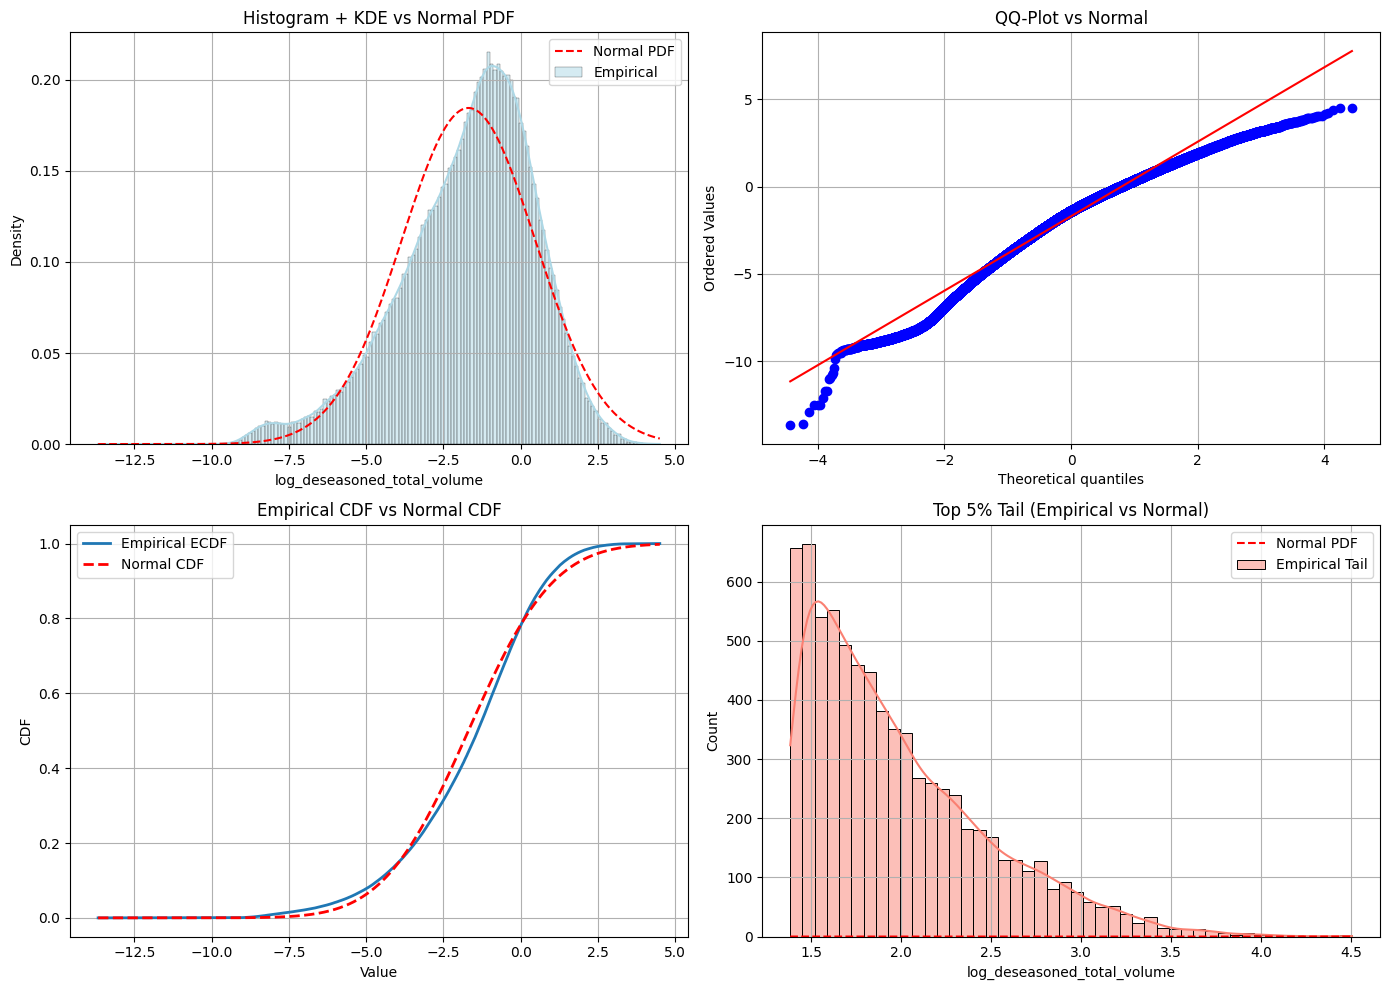

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Ensure `data` is a 1D NumPy array
# data = df["log_deseasoned_total_volume"].values.flatten()

# Fit normal distribution
mu, std = norm.fit(data)

# ECDF data
sorted_data = np.sort(data)
ecdf_y = np.linspace(0, 1, len(data))

# Plot
plt.figure(figsize=(14, 10))

# 1. Histogram + KDE
plt.subplot(2, 2, 1)
sns.histplot(data, kde=True, stat="density", color='lightblue', label="Empirical")
x_vals = np.linspace(min(data), max(data), 1000)
plt.plot(x_vals, norm.pdf(x_vals, mu, std), 'r--', label="Normal PDF")
plt.title("Histogram + KDE vs Normal PDF")
plt.legend()
plt.grid(True)

# 2. QQ-Plot vs Normal
plt.subplot(2, 2, 2)
stats.probplot(data, dist="norm", plot=plt)
plt.title("QQ-Plot vs Normal")
plt.grid(True)

# 3. ECDF vs Normal CDF
plt.subplot(2, 2, 3)
plt.plot(sorted_data, ecdf_y, label="Empirical ECDF", lw=2)
plt.plot(sorted_data, norm.cdf(sorted_data, mu, std), 'r--', label="Normal CDF", lw=2)
plt.title("Empirical CDF vs Normal CDF")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)

# 4. Top 5% Tail
plt.subplot(2, 2, 4)
tail = data[data > np.percentile(data, 95)]
sns.histplot(tail, kde=True, color='salmon', label="Empirical Tail")
x_tail = np.linspace(min(tail), max(tail), 500)
plt.plot(x_tail, norm.pdf(x_tail, mu, std), 'r--', label="Normal PDF")
plt.title("Top 5% Tail (Empirical vs Normal)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


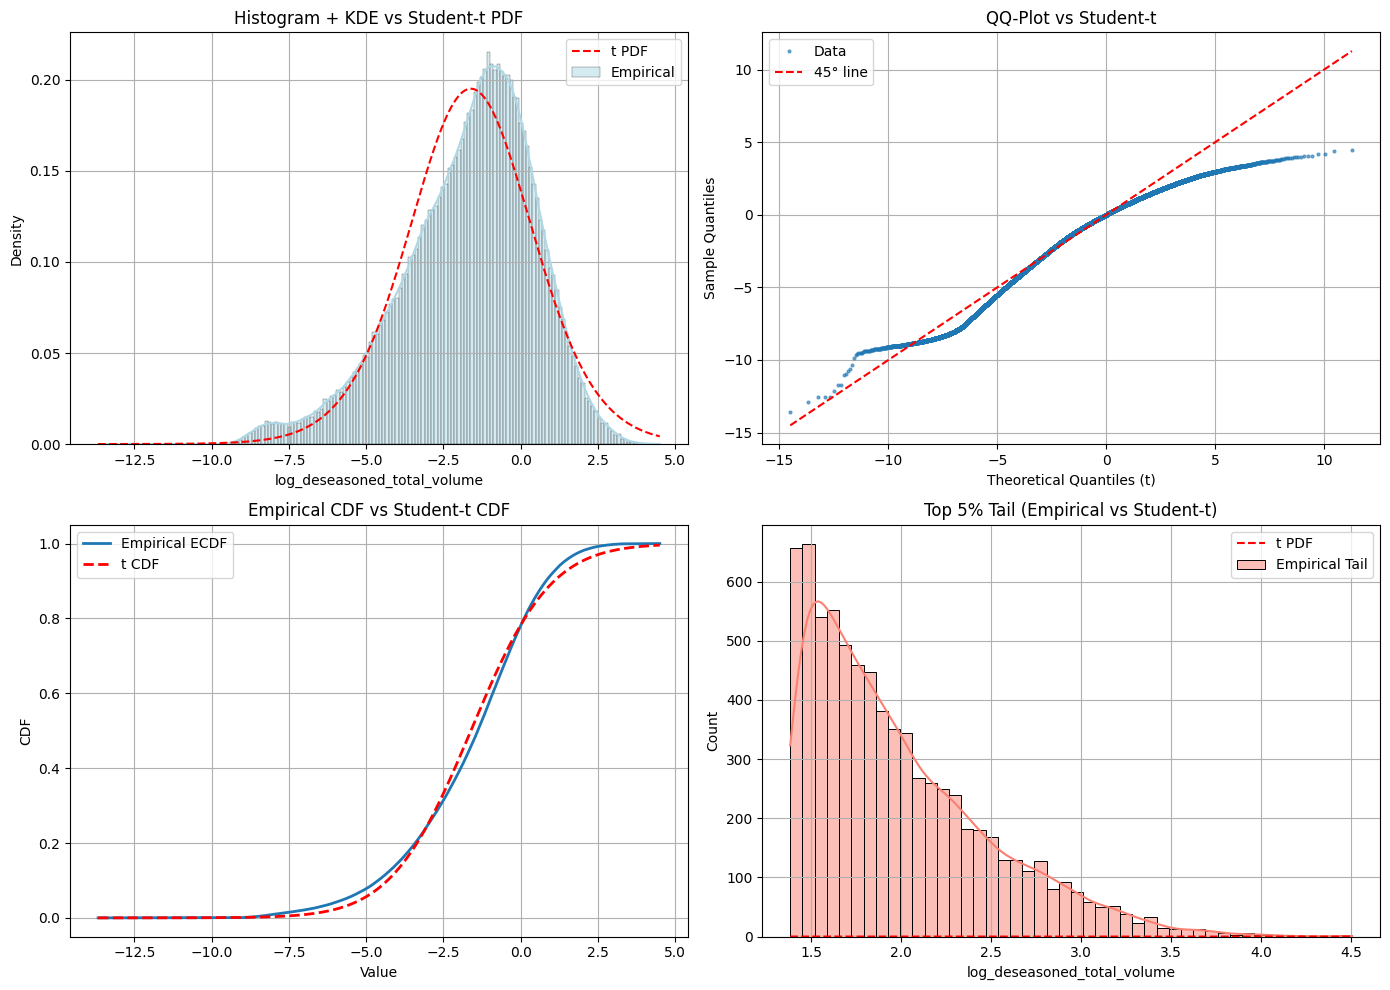

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t


# Fit t-distribution to the data
df_t, loc_t, scale_t = t.fit(data)

# ECDF data
sorted_data = np.sort(data)
ecdf_y = np.linspace(0, 1, len(data))

# Plot
plt.figure(figsize=(14, 10))

# 1. Histogram + KDE vs Student-t PDF
plt.subplot(2, 2, 1)
sns.histplot(data, kde=True, stat="density", color='lightblue', label="Empirical")
x_vals = np.linspace(min(data), max(data), 1000)
plt.plot(x_vals, t.pdf(x_vals, df_t, loc=loc_t, scale=scale_t), 'r--', label="t PDF")
plt.title("Histogram + KDE vs Student-t PDF")
plt.legend()
plt.grid(True)

# 2. QQ-Plot vs Student-t
plt.subplot(2, 2, 2)
theoretical_quantiles = t.ppf(ecdf_y, df=df_t, loc=loc_t, scale=scale_t)
plt.plot(theoretical_quantiles, sorted_data, 'o', markersize=2, alpha=0.6, label="Data")
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label="45° line")
plt.xlabel("Theoretical Quantiles (t)")
plt.ylabel("Sample Quantiles")
plt.title("QQ-Plot vs Student-t")
plt.grid(True)
plt.legend()

# 3. ECDF vs Student-t CDF
plt.subplot(2, 2, 3)
plt.plot(sorted_data, ecdf_y, label="Empirical ECDF", lw=2)
plt.plot(sorted_data, t.cdf(sorted_data, df_t, loc=loc_t, scale=scale_t), 'r--', label="t CDF", lw=2)
plt.title("Empirical CDF vs Student-t CDF")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)

# 4. Top 5% Tail
plt.subplot(2, 2, 4)
tail = data[data > np.percentile(data, 95)]
sns.histplot(tail, kde=True, color='salmon', label="Empirical Tail")
x_tail = np.linspace(min(tail), max(tail), 500)
plt.plot(x_tail, t.pdf(x_tail, df_t, loc=loc_t, scale=scale_t), 'r--', label="t PDF")
plt.title("Top 5% Tail (Empirical vs Student-t)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


This uses the Azzalini skewed t formulation:

$$
f(x ; \xi, \omega, \alpha, \nu)=\frac{2}{\omega} t_\nu\left(\frac{x-\xi}{\omega}\right) T_{\nu+1}\left(\alpha \cdot \frac{x-\xi}{\omega} \cdot \sqrt{\frac{\nu+1}{\nu+\left(\frac{x-\xi}{\omega}\right)^2}}\right)
$$


Where:
- $t_\nu$ : standard t PDF
- $T_{\nu+1}$ : CDF of t-distribution
- $\xi$ : location
- $\omega>0$ : scale
- $\alpha$ : skewness
- $\nu>0$ : degrees of freedom

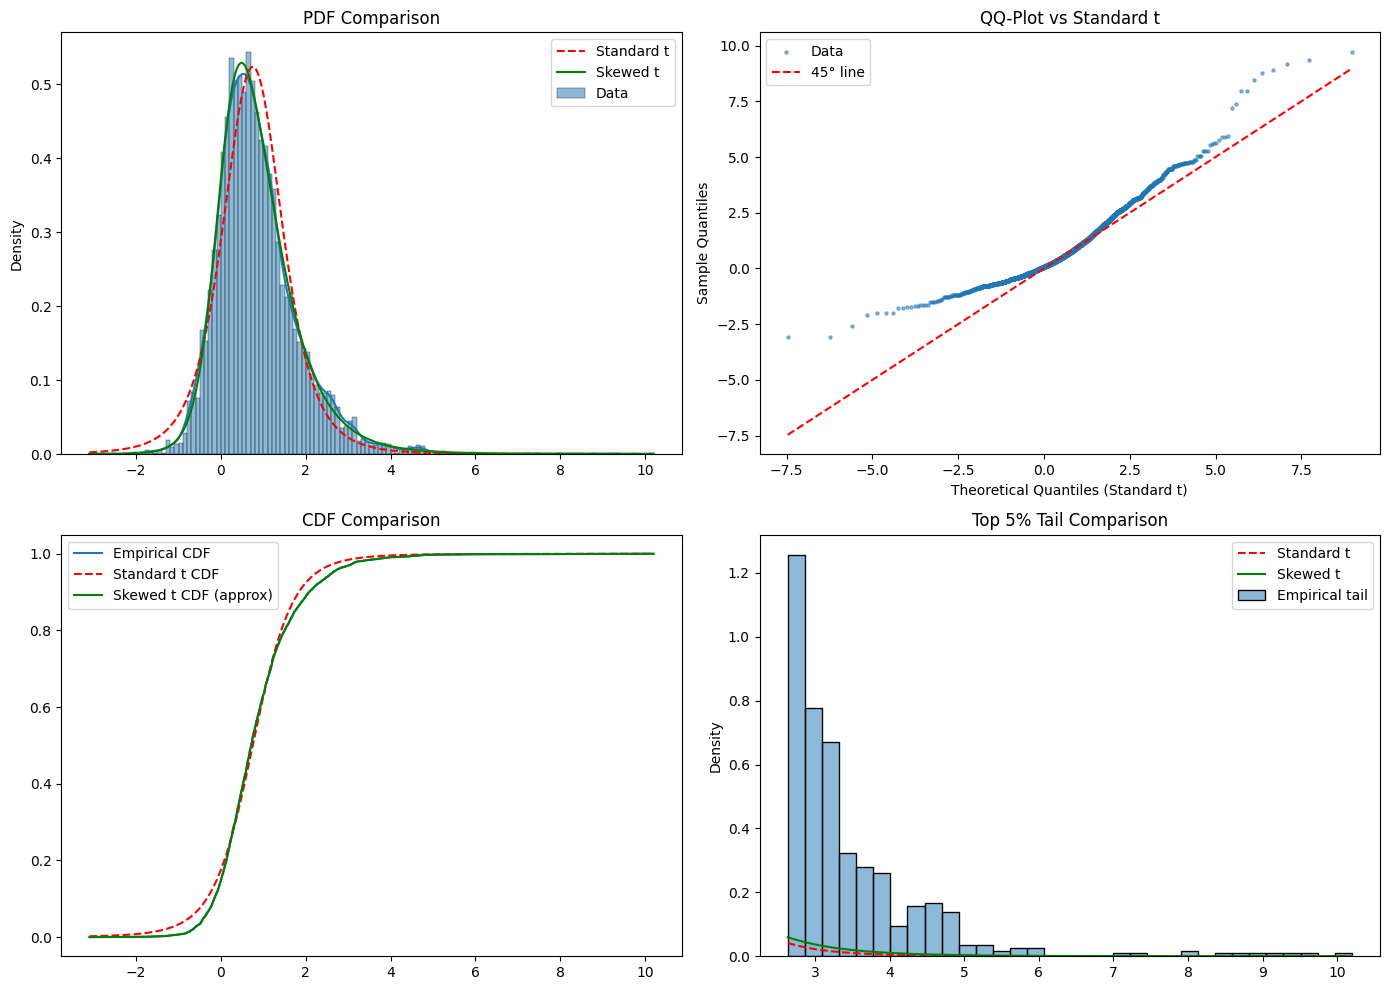

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t as student_t
from scipy.optimize import minimize

# 1. Define the Azzalini skewed t PDF
def skewed_t_pdf(x, xi, omega, alpha, nu):
    z = (x - xi) / omega
    t_nu = student_t.pdf(z, df=nu)
    scale_factor = alpha * z * np.sqrt((nu + 1) / (nu + z**2))
    T_nu_plus_1 = student_t.cdf(scale_factor, df=nu + 1)
    return (2 / omega) * t_nu * T_nu_plus_1

# 2. Negative log-likelihood for MLE
def neg_log_likelihood(params, data):
    xi, omega, alpha, nu = params
    if omega <= 0 or nu <= 0:
        return np.inf
    pdf_vals = skewed_t_pdf(data, xi, omega, alpha, nu)
    return -np.sum(np.log(pdf_vals + 1e-12))  # Avoid log(0)

# 3. Fit skewed t-distribution to your data
def fit_skewed_t(data, initial_params=None):
    if initial_params is None:
        initial_params = [np.median(data), np.std(data), 0, 5]  # Sensible defaults
    bounds = [(None, None), (1e-6, None), (None, None), (1e-6, None)]
    result = minimize(neg_log_likelihood, initial_params, args=(data,), bounds=bounds)
    return result.x


# Fit the distributions
fitted_params = fit_skewed_t(data)
df_t, loc_t, scale_t = student_t.fit(data)  # Standard t-fit

# Generate plots
plt.figure(figsize=(14, 10))
sorted_data = np.sort(data)
ecdf = np.arange(1, len(data)+1) / len(data)
x_vals = np.linspace(min(data), max(data), 500)

# Plot 1: Histogram + KDE vs PDFs
plt.subplot(2, 2, 1)
sns.histplot(data, kde=True, stat="density", alpha=0.5, label="Data")
plt.plot(x_vals, student_t.pdf(x_vals, df_t, loc_t, scale_t), 'r--', label="Standard t")
plt.plot(x_vals, skewed_t_pdf(x_vals, *fitted_params), 'g-', label="Skewed t")
plt.title("PDF Comparison")
plt.legend()

# Plot 2: QQ-Plot vs Standard t
plt.subplot(2, 2, 2)
theoretical_quantiles = student_t.ppf(ecdf, df_t, loc_t, scale_t)
plt.scatter(theoretical_quantiles, sorted_data, s=5, alpha=0.5, label="Data")
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label="45° line")
plt.xlabel("Theoretical Quantiles (Standard t)")
plt.ylabel("Sample Quantiles")
plt.title("QQ-Plot vs Standard t")
plt.legend()

# Plot 3: ECDF vs CDFs
plt.subplot(2, 2, 3)
plt.plot(sorted_data, ecdf, label="Empirical CDF")
plt.plot(sorted_data, student_t.cdf(sorted_data, df_t, loc_t, scale_t), 'r--', label="Standard t CDF")
# Skewed t CDF (approximate via numerical integration)
skewed_cdf = np.array([np.mean(data <= x) for x in sorted_data])  # Empirical (or use quadrature)
plt.plot(sorted_data, skewed_cdf, 'g-', label="Skewed t CDF (approx)")
plt.title("CDF Comparison")
plt.legend()

# Plot 4: Top 5% Tail
plt.subplot(2, 2, 4)
tail_threshold = np.percentile(data, 95)
tail_data = data[data > tail_threshold]
sns.histplot(tail_data, stat="density", alpha=0.5, label="Empirical tail")
x_tail = np.linspace(tail_threshold, max(data), 200)
plt.plot(x_tail, student_t.pdf(x_tail, df_t, loc_t, scale_t), 'r--', label="Standard t")
plt.plot(x_tail, skewed_t_pdf(x_tail, *fitted_params), 'g-', label="Skewed t")
plt.title("Top 5% Tail Comparison")
plt.legend()

plt.tight_layout()
plt.show()